In [54]:
import torch
import gpytorch

from botorch.models import SingleTaskGP
from gpytorch.kernels.rbf_kernel import RBFKernel

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.transforms.outcome import Standardize

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
###
#  fix Cholecky jitter error:
#  the line search in the L-BFGS algorithm, used by default, can take some very large steps, 
#  which in turn causes numerical issues in the solves in the underlying gpytorch model.
#
#  recommended solution: use an optimizer from torch.optim to fit the model
#  see [posted issue here](https://github.com/pytorch/botorch/issues/179#issuecomment-504798767)
###
from botorch.optim.fit import fit_gpytorch_torch 
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

import h5py
import pickle
import os
import time

# load data

In [58]:
file = h5py.File("./targets_and_normalized_features.jld2", "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))
# simulation data (high fidelity)
y = torch.from_numpy(np.transpose(file["gcmc_y"][:]))
y_lo = torch.from_numpy(np.transpose(file["henry_y"][:]))

# total number of COFs in data set
nb_COFs = X.shape[0]

# for training GP and visualizing its performance

In [90]:
# construct and fit GP model
def construct_and_fit_gp_model(X_train, y_train):      
    model = SingleTaskGP(X_train, y_train, outcome_transform=Standardize(m=1), covar_module=RBFKernel())
    mll   = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch)
    return model

In [98]:
def viz_perf(y_test, y_pred, title="", savename=""):
    plt.figure()
    plt.scatter(y_test, y_pred, marker="o", fc="None", ec="green")
    plt.xlabel("high-fidelity\nXe/Kr selectivity")
    plt.ylabel("predicted\nhigh-fidelity\nXe/Kr selectivity")
    plt.gca().set_aspect('equal', 'box')
    plt.plot([0, 20], [0, 20], color="gray", linewidth=1, linestyle="--")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.title(title)

    r2 = r2_score(y_test, y_pred)
    abserr = mean_absolute_error(y_test, y_pred)
    plt.text(5, 15, "R$^2$=%.2f\nMAE=%.2f" % (r2, abserr))
    plt.tight_layout()
    plt.savefig(savename, format="pdf")
    plt.show()

# split data

In [61]:
ids_train, ids_test = train_test_split(range(nb_COFs), test_size=0.2)

In [62]:
# train surrogate model for test data, on acquired set up till top COF was found.
X_train = X[ids_train, :]
X_test  = X[ids_test, :]

y_train = y[ids_train].unsqueeze(-1)
y_test  = y[ids_test].unsqueeze(-1)

now add low-fidelity selectivity as a feature

In [74]:
X_w_y_lo = torch.cat((X, y_lo.unsqueeze(dim=-1)), dim=1)

In [76]:
X_w_y_lo.size()

torch.Size([608, 15])

In [78]:
X_w_y_lo_train = X_w_y_lo[ids_train, :]
X_w_y_lo_test = X_w_y_lo[ids_test, :]

# train and test GP with structural and chemical features

In [92]:
gp = construct_and_fit_gp_model(X_train, y_train)
gp_posterior = gp.posterior(X_test)
y_pred = gp_posterior.mean.squeeze().detach().numpy()

Iter 10/100: 1.3471854673198576
Iter 20/100: 1.216774718740969
Iter 30/100: 1.0257586873549598
Iter 40/100: 0.8954551853000788


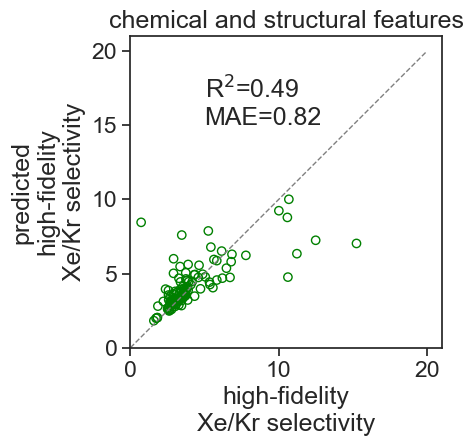

In [99]:
viz_perf(y_test, y_pred, title="chemical and structural features", savename="ordinary_ML.pdf")

# train and test GP with structural and chemical features _and_ low-fidelity Xe/Kr selectivity

In [94]:
gp_w_y_lo = construct_and_fit_gp_model(X_w_y_lo_train, y_train)
gp_posterior_w_y_lo = gp_w_y_lo.posterior(X_w_y_lo_test)
y_pred_w_y_lo = gp_posterior_w_y_lo.mean.squeeze().detach().numpy()

Iter 10/100: 1.2818166858742794
Iter 20/100: 1.0592606717505735
Iter 30/100: 0.6508242902607739
Iter 40/100: -0.05375734508559952


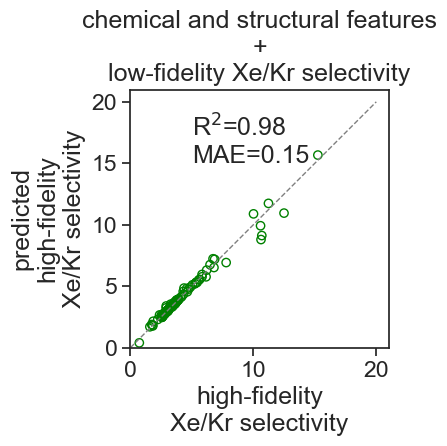

In [100]:
viz_perf(y_test, y_pred_w_y_lo, title="chemical and structural features\n+\nlow-fidelity Xe/Kr selectivity", savename="ordinary_ML_w_y_lo.pdf")